In [2]:
import numpy as NP
import theano
import theano.tensor as T
import theano.tensor.nnet as NN
from cifar_data import *
from wrapper import *

batch_size= 1
drop1 = Dropout(shape=(batch_size, 32, 16, 16), prob=0.25)
drop2 = Dropout(shape=(batch_size, 64, 8, 8), prob=0.25)
drop3 = Dropout(shape=(batch_size, 512), prob=0.5)

#define the input
img_in = T.tensor4()
label_in = T.ivector()

#define the network
def get_expression(model, train, img_in, label_in):
    conv1 = relu(model.conv(img_in, name='conv1', shape=(32, 3, 3, 3, 1, 1)))
    conv2 = relu(model.conv(conv1, name='conv2', shape=(32, 32, 3, 3, 1, 1)))
    pool1 = model.pooling(conv2, name='pool1', shape=(2,2))
    if train:
        pool1 = drop1.drop(pool1)

    conv3 = relu(model.conv(pool1, name='conv3', shape=(64, 32, 3, 3, 1, 1)))
    conv4 = relu(model.conv(conv3, name='conv4', shape=(64, 64, 3, 3, 1, 1)))
    pool2 = model.pooling(conv4, name='pool2', shape=(2,2))
    if train:
        pool2 = drop2.drop(pool2)

    fc1 = relu(model.fc(pool2.reshape((batch_size, -1)), name='fc1', shape=(4096, 512)))
    if train:
        fc1 = drop3.drop(fc1)
    fc2 = softmax(model.fc(fc1, name='fc2', shape=(512, 10)))

    loss = T.mean(NN.categorical_crossentropy(fc2, label_in))

    if train:
        grads = rmsprop(loss, model.get_params(), return_norm=False)
        return loss, fc2, grads
    else:
        return loss, fc2 , pool1, pool2, conv1

print 'Compile'
model = Model()

l, o, p1, p2,c1 = get_expression(model, False, img_in, label_in)
test_func = theano.function([img_in, label_in], [l,o,p1,p2,c1], allow_input_downcast=True)

model.load('cifar_save_199')
cifar_data = load_cifar()

cifar_data['label_name'] = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

Compile
conv1 {'shape': (32, 3, 3, 3, 1, 1)}
conv2 {'shape': (32, 32, 3, 3, 1, 1)}
pool1 {'shape': (2, 2)}
conv3 {'shape': (64, 32, 3, 3, 1, 1)}
conv4 {'shape': (64, 64, 3, 3, 1, 1)}
pool2 {'shape': (2, 2)}
fc1 {'shape': (4096, 512)}
fc2 {'shape': (512, 10)}


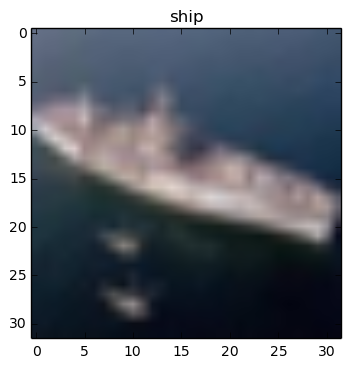

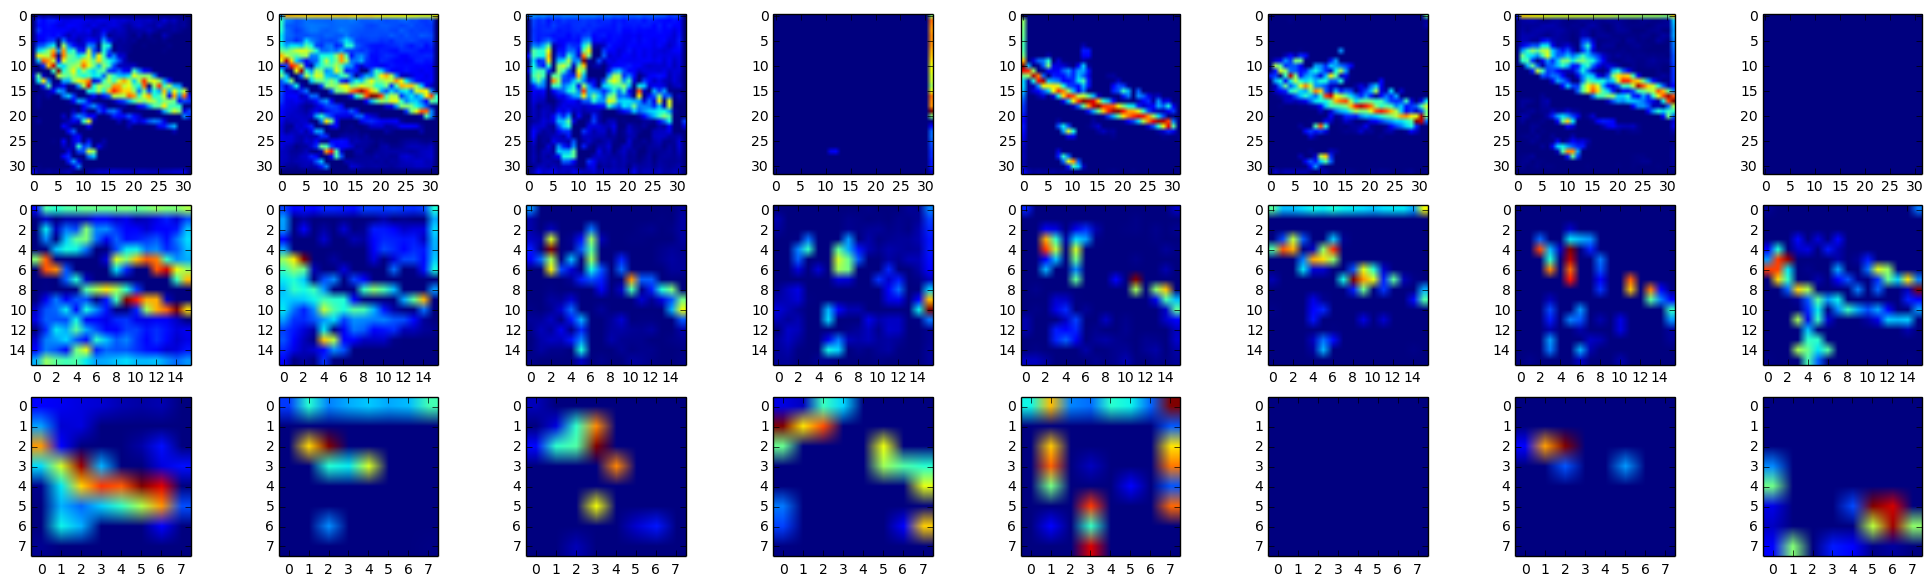

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib.pyplot as plt
idx = 789
t_img = cifar_data['test_data'][idx].reshape((1, 3, 32, 32))
t_label = cifar_data['test_label'][idx]
plt.imshow(t_img[0].transpose(1,2,0))
plt.title(cifar_data['label_name'][t_label])
plt.show()


loss, net_out, pool1, pool2, conv1 = test_func(t_img, NP.asarray([t_label]))

f, (ax0, ax1, ax2) = plt.subplots(3, 8, figsize=(25,7))
for i in xrange(8):
    ax0[i].imshow(conv1[0][i])
    ax1[i].imshow(pool1[0][i])
    ax2[i].imshow(pool2[0][i])
plt.show()